# Library Imports & Helper Functions

In [1]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import community.community_louvain as ml
from collections import Counter

In [2]:
def analyze_community_composition(G, attribute_name, plot_title, legend_title, min_size=11, top_n=20):
    """
    Analyzes community composition.
    - Generates a Stacked Bar Chart.
    - Generates a Heatmap (better for reading values).
    """

    print(f"ANALYSIS: Community vs. {attribute_name}")

    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])

    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return

    # clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return  ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # filter Data (Size)
    true_community_sizes = df['community'].value_counts()
    communities_to_keep = true_community_sizes[true_community_sizes >= min_size].index
    df_filtered = df[df['community'].isin(communities_to_keep)].copy()

    # group Rare Categories into 'Other'
    category_counts = df_filtered[attribute_name].value_counts()
    top_categories = category_counts.nlargest(top_n).index
    
    df_filtered[attribute_name] = df_filtered[attribute_name].apply(
        lambda x: x if x in top_categories else 'other'
    )
    
    print(f"Note: Grouped {len(category_counts) - top_n} rare categories into 'Other'.")

   # create Crosstab
    contingency_table = pd.crosstab(df_filtered['community'], df_filtered[attribute_name])

    
    # Sorts 'Community_1', 'Community_2', ... 'Community_10' correctly
    try:
        sorted_index = sorted(contingency_table.index, key=lambda x: int(str(x).split('_')[1]))
        contingency_table = contingency_table.reindex(sorted_index)
    except Exception as e:
        print(f"Warning: Could not sort numerically ({e}). Fallback to standard sort.")
        contingency_table['TOTAL'] = contingency_table.sum(axis=1)
        contingency_table = contingency_table.sort_values('TOTAL', ascending=False)
        del contingency_table['TOTAL']
    
    
    purity_calc = contingency_table # table is already sorted now
    community_purity = purity_calc.div(purity_calc.sum(axis=1), axis=0).fillna(0) * 100

    # PLOT 1: Stacked Bar Chart
    fig, ax = plt.subplots(figsize=(10, 6))
      
    colors = plt.cm.tab20.colors
    color_map = {}
    color_idx = 0
    for cat in community_purity.columns:
        if cat == 'other':
            color_map[cat] = 'black' 
        else:
            color_map[cat] = colors[color_idx % 20]
            color_idx += 1
    
    community_purity.plot(kind='bar', stacked=True, ax=ax, color=[color_map.get(x, 'gray') for x in community_purity.columns])

    ax.set_title(f'{plot_title} (Top {top_n})', fontsize=16)
    ax.set_xlabel('Community ID', fontsize=12)
    ax.set_ylabel(f'Percentage (%)', fontsize=12)
    ax.legend(title=legend_title, bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # PLOT 2: Heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        community_purity, 
        annot=True,      # Show numbers
        fmt=".0f",       # Round to whole numbers
        cmap="YlGnBu",   # Color scheme
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )
    plt.title(f'{plot_title}', fontsize=16)
    plt.xlabel(legend_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [3]:
# MASTER FUNCTION: Deep Dive Heatmap (No 'Other')
def plot_deep_dive_heatmap(G, attribute_name, plot_title, xlabel_title, min_size=11, threshold_percent=20):
    """
    Generates a detailed heatmap EXCLUDING the 'Other' category.
    Displays EVERY category that has a proportion greater than 
    'threshold_percent' in AT LEAST ONE community.
    """
    print(f"DEEP DIVE HEATMAP: {attribute_name}")


    # fetch data
    data = G.nodes(data=True)
    df = pd.DataFrame([d for n, d in data])
    
    if 'community' not in df.columns or attribute_name not in df.columns:
        print(f" ERROR: Attribute '{attribute_name}' missing.")
        return
    
    # clean Categories
    def sort_categories(value):
        if isinstance(value, str) and value.startswith('{') and value.endswith('}'):
            content = value.replace('{', '').replace('}', '').replace('"', '').strip()
            parts = sorted(content.split(','))
            return  ",".join(parts)
        return value
    df[attribute_name] = df[attribute_name].apply(sort_categories)

    # create Crosstab
    true_community_sizes = df['community'].value_counts()
    contingency_table = pd.crosstab(df['community'], df[attribute_name])

    # 3. Filter & SORT Communities (1, 2, 3...)
    # First, filter out those that are too small
    communities_subset = true_community_sizes[true_community_sizes >= min_size].index
    
    # NOW sort the remaining ones strictly by number (Community_1, Community_2...)
    try:
        sorted_communities = sorted(communities_subset, key=lambda x: int(str(x).split('_')[1]))
    except:
        # Fallback if the name is not "Community_X"
        sorted_communities = communities_subset
        
    # Reorder table
    filtered_contingency = contingency_table.reindex(sorted_communities).fillna(0)

    # calculate puity
    community_purity = filtered_contingency.div(filtered_contingency.sum(axis=1), axis=0) * 100
    
    cols_to_drop = [c for c in community_purity.columns if 'other' in str(c).lower()]
    if cols_to_drop:
        community_purity = community_purity.drop(columns=cols_to_drop)

    # filter
    important_cols = community_purity.columns[(community_purity >= threshold_percent).any()]
    df_heatmap = community_purity[important_cols]
    
    print(f"Showing {len(important_cols)} categories that are >{threshold_percent}% abundant in at least one cluster.")

    if df_heatmap.empty:
        print("No categories met the threshold.")
        return

    # plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        df_heatmap, 
        annot=True, 
        fmt=".0f", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=.5
    )

    plt.title(f'{plot_title} (Threshold: >{threshold_percent}%)', fontsize=16)
    plt.xlabel(xlabel_title, fontsize=12)
    plt.ylabel('Community ID', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [4]:
# Load raw graph
G_glasso_raw = nx.read_gexf("../data/new_data_glasso_network_FILTERED.gexf")

G_glasso_raw = nx.relabel_nodes(G_glasso_raw, str)

# Loop over the main graph to create a 'distance' attribute
for u, v, data in G_glasso_raw.edges(data=True):
    strength = data['weight'] # This is the precision value
    
    # Create the 'distance' attribute for path-finding
    # 1 / strength
    # This way, high strength (strong connection) = low distance (short path)
    distance = 1.0 / strength
    G_glasso_raw.edges[u, v]['distance'] = distance

# Structure Analysis & Topology

In [5]:
# find connected components
connected_components = list(nx.connected_components(G_glasso_raw))

# 1. Largest component (Index 0)
giant_component_nodes = connected_components[0]
print(f"1. Largest island (giant component) raw size: {len(giant_component_nodes)}")

# A. sort nodes alphabetically
sorted_nodes = sorted(list(giant_component_nodes))

# B. sort edges
temp_subgraph = G_glasso_raw.subgraph(sorted_nodes)
# Sortierung nach (Startknoten, Endknoten), damit sie immer in gleicher Reihenfolge kommen
sorted_edges = sorted(temp_subgraph.edges(data=True), key=lambda x: (x[0], x[1]))

# C. create new graph
G_core = nx.Graph()

# D. add in distinct order
G_core.add_nodes_from(sorted_nodes)
G_core.add_edges_from(sorted_edges) 

node_attrs = {n: G_glasso_raw.nodes[n] for n in sorted_nodes}
nx.set_node_attributes(G_core, node_attrs)

print(f"Core Graph created (Stable Sort).")
print(f"Nodes: {G_core.number_of_nodes()}, Edges: {G_core.number_of_edges()}")

1. Largest island (giant component) raw size: 440
Core Graph created (Stable Sort).
Nodes: 440, Edges: 1376


In [6]:
# all calculations only on G_core
# Degree (Unweighted)
# Identifies structural hubs based on connection count
degree_dict = dict(G_core.degree())
nx.set_node_attributes(G_core, degree_dict, 'degree')

# Betweenness (Weighted)
# uses 'weight="distance"' to find the most efficient (lowest cost) paths.
betweenness = nx.betweenness_centrality(G_core, normalized=True, weight="distance")
nx.set_node_attributes(G_core, betweenness, 'betweenness_score')

# Node Strength (Weighted Degree)
# Sum of edge weights (using 'weight', which is your precision value)
node_strength = dict(G_core.degree(weight='weight'))
nx.set_node_attributes(G_core, node_strength, 'node_strength')
    
# Top 10 Betweenness
df_betweenness = pd.DataFrame(sorted(betweenness.items(), key=lambda item: item[1], reverse=True),
                              columns=['gcf_id', 'betweenness_score'])
print("\nTop 10 GCFs (Betweenness Centrality)")
print(df_betweenness.head(10).to_string())

# Top 10 Node Strength
df_strength = pd.DataFrame(sorted(node_strength.items(), key=lambda item: item[1], reverse=True),
                           columns=['gcf_id', 'node_strength'])
print("\nTop 10 GCFs (Node Strength)")
print(df_strength.head(10).to_string())




Top 10 GCFs (Betweenness Centrality)
           gcf_id  betweenness_score
0  GCF_c007ec0dcc           0.501233
1  GCF_3d3b9d6d75           0.324939
2  GCF_32a52f3443           0.241905
3  GCF_0970e9a3e2           0.161908
4  GCF_3bf7c2fc79           0.158174
5  GCF_ba98f56db5           0.153036
6  GCF_fbe378499e           0.114800
7  GCF_8c7b546f7e           0.113718
8  GCF_e468c5d75d           0.111597
9  GCF_0f8a262ffa           0.111170

Top 10 GCFs (Node Strength)
           gcf_id  node_strength
0  GCF_3bf7c2fc79    1723.379883
1  GCF_32a52f3443    1533.170531
2  GCF_e468c5d75d    1288.983281
3  GCF_45129e2542    1024.656180
4  GCF_8c7b546f7e     983.730504
5  GCF_c007ec0dcc     900.838403
6  GCF_ba98f56db5     739.760927
7  GCF_63987ec8fe     604.300383
8  GCF_c3a8a867c3     574.862886
9  GCF_0f8a262ffa     535.916112


In [7]:
# betweenness centrality
# calculates node importance as a 'bridge' on shortest paths.
#'weight="weight"', as it seeks paths with the lowest distance
betweenness = nx.betweenness_centrality(G_core, normalized=True, weight="distance")

# add scores to graph node
nx.set_node_attributes(G_core, betweenness, 'betweenness_score')

# Sort and create DataFrame
sorted_betweenness = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
df_scores = pd.DataFrame(sorted_betweenness, columns=['gcf_id', 'betweenness_score'])

# print
print("Top 10 GCFs (Betweenness Centrality)")
print(df_scores.head(10).to_string())

Top 10 GCFs (Betweenness Centrality)
           gcf_id  betweenness_score
0  GCF_c007ec0dcc           0.501233
1  GCF_3d3b9d6d75           0.324939
2  GCF_32a52f3443           0.241905
3  GCF_0970e9a3e2           0.161908
4  GCF_3bf7c2fc79           0.158174
5  GCF_ba98f56db5           0.153036
6  GCF_fbe378499e           0.114800
7  GCF_8c7b546f7e           0.113718
8  GCF_e468c5d75d           0.111597
9  GCF_0f8a262ffa           0.111170


In [8]:
#harmonic centrality
# Calculates how 'central' a node is, but works on disconnected graphs (islands).
# uses 'distance="distance"' to use edge attribute
harmonic_raw = nx.harmonic_centrality(G_core, distance="distance")

# Normalize the scores
n = G_core.number_of_nodes()
harmonic_normalized = {node: score / (n - 1) for node, score in harmonic_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_core, harmonic_normalized, 'harmonic_score')

# Sort and create DataFrame
df_harmonic = pd.DataFrame(sorted(harmonic_normalized.items(), key=lambda item: item[1], reverse=True),
                           columns=['gcf_id', 'harmonic_score'])

# print
print("Top 10 GCFs (Harmonic Centrality)")
print(df_harmonic.head(10).to_string())

Top 10 GCFs (Harmonic Centrality)
           gcf_id  harmonic_score
0  GCF_3bf7c2fc79        7.848313
1  GCF_32a52f3443        7.084221
2  GCF_e468c5d75d        6.512311
3  GCF_45129e2542        6.481051
4  GCF_e5c7efbe15        6.275530
5  GCF_225d354f00        6.231839
6  GCF_65ea18afe8        6.200129
7  GCF_5bffcb396a        6.110911
8  GCF_435c3e7244        6.086520
9  GCF_6a76758c19        6.029698


In [9]:
# neighborhood connectivity
# calculates the average degree of a node's neighbors. A high score means a 'hub of hubs'.
# uses 'weight="strength"' to see if neighbors have strong connections.
neighbor_conn_raw = nx.average_neighbor_degree(G_core, weight="strength")

# Normalize the scores
n = G_core.number_of_nodes()
neighbor_conn_normalized = {node: score / (n - 1) for node, score in neighbor_conn_raw.items()}

# add scores to graph node
nx.set_node_attributes(G_core, neighbor_conn_normalized, 'neighborhood_connectivity')

# Sort and create DataFrame
df_neighbor_conn = pd.DataFrame(sorted(neighbor_conn_normalized.items(), key=lambda item: item[1], reverse=True),
                                columns=['gcf_id', 'neighborhood_connectivity'])

# print
print("Top 10 GCFs (Neighborhood Connectivity)")
print(df_neighbor_conn.head(10).to_string())

Top 10 GCFs (Neighborhood Connectivity)
           gcf_id  neighborhood_connectivity
0  GCF_1947d1eb53                   0.316629
1  GCF_30da925432                   0.316629
2  GCF_3112f50dac                   0.316629
3  GCF_31755da47f                   0.316629
4  GCF_35ea0af7dd                   0.316629
5  GCF_363b838d6b                   0.316629
6  GCF_3a299fc714                   0.316629
7  GCF_4161d01a59                   0.316629
8  GCF_4490b2dbc1                   0.316629
9  GCF_497770fd46                   0.316629


In [10]:
# Louvain communities
# Uses 'weight="weight"' because that is the attribute from your Glasso graph
# resolution under 3 resulted in a community with 101 GCFs (approx. 23 %) 
partition = community_louvain.best_partition(G_core, weight='weight', random_state=42, resolution=4)

# 1. Count the size of each community
counts = Counter(partition.values())

# 2. Sort IDs by size (descending), so the largest comes first
sorted_ids = sorted(counts, key=counts.get, reverse=True)

# 3. Create a mapping: Old ID -> "Community_1", "Community_2", etc.
new_names_map = {old_id: f"Community_{rank}" for rank, old_id in enumerate(sorted_ids, 1)}

# 4. Apply the new names to the nodes
community_dict = {node: new_names_map[old_id] for node, old_id in partition.items()}

# Add the new attribute 'community' to every node in G_core
nx.set_node_attributes(G_core, community_dict, 'community')

# Show the Top 15 largest communities 
print("\nTop 15 Largest Communities (in G_core):")
# calculate sizes
size_map = pd.Series(community_dict).value_counts()


for i in range(1, 16):
    name = f"Community_{i}"
    if name in size_map:
        print(f"{name}: {size_map[name]} members")
        
q_score = ml.modularity(partition, G_core, weight='weight') 
print(f"Modularität: {q_score:.3f}")


Top 15 Largest Communities (in G_core):
Community_1: 53 members
Community_2: 48 members
Community_3: 41 members
Community_4: 30 members
Community_5: 29 members
Community_6: 26 members
Community_7: 24 members
Community_8: 24 members
Community_9: 20 members
Community_10: 17 members
Community_11: 16 members
Community_12: 14 members
Community_13: 12 members
Community_14: 11 members
Community_15: 11 members
Modularität: 0.615


# Attribute Mapping

In [11]:
# ---------------------------------------------------------
# 1. LOAD GCF FILES (GCF Mapping) - MIT FIX
# ---------------------------------------------------------
try:
    file_metalog_gcf = "../data/metalog_bgcs_with_gcf_and_tax.tsv"
    file_mgnify_gcf = "../data/mgnify_bgcs_with_gcf_and_tax.tsv"
    
    print("Loading GCF mapping files...")
    # Nutze r'\s+' wie im erfolgreichen Code
# --- FIX: Nutze sep='\t' statt r'\s+' für TSV Dateien ---
    df_gcf_metalog = pd.read_csv(file_metalog_gcf, sep='\t', on_bad_lines='skip')
    df_gcf_mgnify = pd.read_csv(file_mgnify_gcf, sep='\t', on_bad_lines='skip')
    
    df_merged = pd.concat([df_gcf_metalog, df_gcf_mgnify], ignore_index=True)

    # --- REINIGUNG (Identisch zum Jaccard-Code) ---
    df_merged = df_merged.dropna(subset=['gcf_id'])
    
    # 1. Den .0 Fix anwenden
    df_merged['gcf_id'] = df_merged['gcf_id'].astype(str).str.replace(r'\.0$', '', regex=True)
    
    # 2. Noise filtern
    noise_list = ["-1", "nan", "None", "", "unknown"]
    df_merged = df_merged[~df_merged["gcf_id"].isin(noise_list)]
    
    # IDs trimmen
    join_col = 'analysis_accession' 
    df_merged[join_col] = df_merged[join_col].astype(str).str.strip()

    print(f"Combined GCF dataset loaded. Total rows: {len(df_merged)}")
    print(f"Unique GCFs identified: {df_merged['gcf_id'].nunique()}") # Jetzt sollten hier 73,520 stehen

except FileNotFoundError:
    print("ERROR: Could not find GCF mapping files.")
# ---------------------------------------------------------
# 2. LOAD & PROCESS SAMPLE METADATA (Optimized)
# ---------------------------------------------------------
print("-" * 50)
print("STEP: SMART BIOME EXTRACTION (Column Combination)")
print("-" * 50)

try:
    print("Loading Sample Metadata (Optimized with usecols)...")
    
    # Wir definieren die Spalten, die wir brauchen. 
    # Das spart RAM und Zeit!
    needed_cols = ['external_id', 'environment_feature', 'environment_biome', 'biome']
    
    # Helper zum Laden
    def load_meta(path):
        return pd.read_csv(
            path, 
            sep='\t', 
            usecols=lambda c: c in needed_cols, # Lädt nur was da ist
            dtype=str, # Alles als String für Sicherheit
            on_bad_lines='skip'
        )

    meta_metalog = load_meta("../data/metalog_samples.tsv")
    meta_mgnify = load_meta("../data/mgnify_samples.tsv") 
    
    # Zusammenfügen
    df_samples = pd.concat([meta_metalog, meta_mgnify], ignore_index=True)
    
    # IDs säubern
    if 'external_id' in df_samples.columns:
        df_samples['external_id'] = df_samples['external_id'].str.strip()
    
    print(f"Total metadata rows loaded: {len(df_samples)}")
    
except FileNotFoundError:
    print("ERROR: Metadata files not found.")
    raise

# ---------------------------------------------------------
# 3. SMART LOGIC FUNCTION (The Improved Version)
# ---------------------------------------------------------
def get_smart_biome(row):
    """
    Combines environment_feature, environment_biome, and the biome lineage.
    Priority: Feature > Environment Biome > Biome Lineage (Last part).
    """
    bad_terms = {'nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic'}

    def clean_val(val):
        s = str(val).strip()
        # ENVO Code entfernen: "lake [ENVO:123]" -> "lake"
        s = s.split('[')[0].strip()
        if s.lower() in bad_terms: return None
        return s.title()

    # 1. Feature (z.B. "Feces")
    feat = clean_val(row.get('environment_feature', ''))
    if feat: return feat

    # 2. Environment Biome (z.B. "Human Gut")
    env_biome = clean_val(row.get('environment_biome', ''))
    if env_biome: return env_biome

    # 3. Biome Lineage (z.B. "root:Host:Human:Digestive system")
    raw_biome = str(row.get('biome', ''))
    if raw_biome.lower() not in bad_terms and raw_biome != 'nan':
        if ':' in raw_biome:
            # Nimm das letzte Wort nach dem Doppelpunkt
            candidate = raw_biome.split(':')[-1].strip()
            return clean_val(candidate)
        return clean_val(raw_biome)

    return "Unknown"

print("Applying smart biome logic...")
df_samples['clean_biome'] = df_samples.apply(get_smart_biome, axis=1)

# Dictionary erstellen (Nur valide Einträge)
valid_samples = df_samples[df_samples['clean_biome'] != "Unknown"]
biome_dict = pd.Series(
    valid_samples['clean_biome'].values, 
    index=valid_samples['external_id']
).to_dict()

print(f"Extracted valid biomes for {len(biome_dict)} samples.")

# ---------------------------------------------------------
# 4. MAPPING TO GCFs & AGGREGATION
# ---------------------------------------------------------
print("Mapping metadata to GCFs...")

# A. Map Sample-Biome to GCF-Table using the Accession ID
df_merged['dominant_biome'] = df_merged[join_col].map(biome_dict).fillna("Unknown")

# B. Aggregieren: Ein GCF kann in mehreren Samples sein -> Nimm das häufigste Biome
def get_most_common(series):
    # Filter "Unknown" out first
    valid = series[series != "Unknown"]
    if not valid.empty:
        return valid.mode().iloc[0] # Returns the most frequent value
    return "Unknown"

# Das hier dauert kurz, weil groupby teuer ist
final_mapping = df_merged.groupby('gcf_id')['dominant_biome'].agg(get_most_common).to_dict()

print(f"Final mapping created for {len(final_mapping)} unique GCFs.")

# ---------------------------------------------------------
# 5. UPDATE GRAPH (Optional Check)
# ---------------------------------------------------------
if 'G_core' in locals():
    print("Updating Graph Nodes...")
    nx.set_node_attributes(G_core, final_mapping, name="dominant_biome")

    # Statistik checken
    labeled_nodes = [n for n, d in G_core.nodes(data=True) if d.get('dominant_biome') not in ["Unknown", None]]
    total_nodes = G_core.number_of_nodes()
    
    print("-" * 30)
    if total_nodes > 0:
        print(f"SUCCESS: {len(labeled_nodes)} / {total_nodes} nodes colored.")
        print(f"Coverage: {len(labeled_nodes) / total_nodes:.1%}")
    else:
        print("Graph is empty.")
    print("-" * 30)
else:
    print("NOTE: 'G_core' variable not found. Mapping dict 'final_mapping' is ready for use.")

Loading GCF mapping files...
Combined GCF dataset loaded. Total rows: 9741406
Unique GCFs identified: 73520
--------------------------------------------------
STEP: SMART BIOME EXTRACTION (Column Combination)
--------------------------------------------------
Loading Sample Metadata (Optimized with usecols)...
Total metadata rows loaded: 76737
Applying smart biome logic...
Extracted valid biomes for 73441 samples.
Mapping metadata to GCFs...
Final mapping created for 73520 unique GCFs.
Updating Graph Nodes...
------------------------------
SUCCESS: 440 / 440 nodes colored.
Coverage: 100.0%
------------------------------


In [12]:
# -----------------------------------------------------------------------------
# ANALYSIS: Source Column Usage (Priority Chain Efficiency)
# -----------------------------------------------------------------------------

def track_biome_sources(df):
    """
    Analyzes which source column was the decisive one for the final label.
    Priority: environment_feature > environment_biome > biome (lineage)
    """
    bad_terms = {'nan', 'none', '', 'mixed', 'other', 'misc', 'unclassified', 'root:mixed', 'generic'}
    
    stats = {
        'environment_feature': 0,
        'environment_biome': 0,
        'biome_lineage': 0,
        'unknown': 0
    }

    def clean_val(val):
        s = str(val).split('[')[0].strip()
        if not s or s.lower() in bad_terms: return None
        return s

    for _, row in df.iterrows():
        # 1. Try Feature
        if clean_val(row.get('environment_feature', '')):
            stats['environment_feature'] += 1
            continue # Priority 1 hit
            
        # 2. Try Environment Biome
        if clean_val(row.get('environment_biome', '')):
            stats['environment_biome'] += 1
            continue # Priority 2 hit
            
        # 3. Try Biome Lineage
        raw_b = str(row.get('biome', ''))
        if raw_b.lower() not in bad_terms and raw_b != 'nan':
            # This counts as a hit for the 'biome' column
            stats['biome_lineage'] += 1
            continue # Priority 3 hit
            
        # 4. Nothing worked
        stats['unknown'] += 1
        
    return stats

# Run the tracker
source_stats = track_biome_sources(df_samples)

# Display the results
print(f"{'Source Column':<25} | {'Decision Count':<15} | {'Efficiency (%)':<10}")
print("-" * 60)
total = sum(source_stats.values())

for source, count in source_stats.items():
    perc = (count / total) * 100
    print(f"{source:<25} | {count:<15} | {perc:<10.2f}%")

print("-" * 60)
print(f"Total Rows Analyzed: {total}")

Source Column             | Decision Count  | Efficiency (%)
------------------------------------------------------------
environment_feature       | 52098           | 67.89     %
environment_biome         | 1431            | 1.86      %
biome_lineage             | 20112           | 26.21     %
unknown                   | 3096            | 4.03      %
------------------------------------------------------------
Total Rows Analyzed: 76737


In [13]:
# ---------------------------------------------------------
# 1. TAXONOMY PARSING (Strings zerlegen)
# ---------------------------------------------------------
if 'mmseqs_taxonomy' in df_merged.columns:
    print("Parsing taxonomy column using Regex...")
    
    # Wir extrahieren die Ebenen basierend auf den Buchstaben  f_, g_, s_
    
    # HIER sind die, die du gesucht hast:
    df_merged['tax_family']  = df_merged['mmseqs_taxonomy'].str.extract(r'f_([^;]+)') # Ersatz für family_id
    df_merged['tax_genus']   = df_merged['mmseqs_taxonomy'].str.extract(r'g_([^;]+)') # Ersatz für genus_id
    df_merged['tax_species'] = df_merged['mmseqs_taxonomy'].str.extract(r's_([^;]+)') # Ersatz für species_id
    
    print("Taxonomy parsing done.")
else:
    print("WARNING: Column 'mmseqs_taxonomy' not found!")

# 2. DEFINE ATTRIBUTES TO ADD
# Hier sind die korrekten Spaltennamen aus deinem Snippet!
attributes_to_add = [
    {'col': 'product_category', 'attr': 'product_categories'},  # Deine Spalte heißt 'product_category'
    {'col': 'product_type',     'attr': 'product_subcategory'}, # Deine Spalte heißt 'product_type'      
    {'col': 'tax_family',        'attr': 'family_id'},            
    {'col': 'tax_genus',         'attr': 'genus_id'},
    {'col': 'tax_species',       'attr': 'species_id'}
]

# WICHTIG: Wähle deinen aktuellen Graphen (z.B. G_spearman oder G_jaccard)
TARGET_GRAPH = G_core # <--- Hier ändern!

# 3. LOOP: PROCESS AND ADD ATTRIBUTES TO GRAPH
print("Mapping attributes to Graph...")

for item in attributes_to_add:
    col_name = item['col']
    attr_name = item['attr']
    
    # Check if column exists in our new data
    if col_name in df_merged.columns:
        print(f"Processing '{attr_name}' from column '{col_name}'...")
        
        # Clean data: Nur Zeilen mit GCF-ID und dem Wert
        # Achtung: Wir nutzen hier 'gcf_id' als Key, weil das so in deiner Datei steht.
        df_clean = df_merged[['gcf_id', col_name]].dropna()
        
        # Remove '0', empty strings, or cleaning artifacts if necessary
        df_clean = df_clean[df_clean[col_name].astype(str) != '0']
        
        if not df_clean.empty:
            # Find dominant value (Mode) for each GCF
            dominant_val = df_clean.groupby('gcf_id')[col_name].agg(
                lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]
            )
            
            # Convert index (GCF ID) to string
            dominant_val.index = dominant_val.index.astype(str)
            attr_dict = dominant_val.to_dict()
            
            # Add attribute to the graph
            nx.set_node_attributes(TARGET_GRAPH, attr_dict, attr_name)
            
            # Success check
            count = len([n for n, d in TARGET_GRAPH.nodes(data=True) if attr_name in d])
            print(f"  -> Added '{attr_name}' to {count} nodes.")
        else:
            print(f"  -> Warning: Column '{col_name}' contains no valid data.")
    else:
        print(f"  -> SKIP: Column '{col_name}' not found in dataset (maybe add Taxonomy later?).")

print("Done adding attributes.")

Parsing taxonomy column using Regex...
Taxonomy parsing done.
Mapping attributes to Graph...
Processing 'product_categories' from column 'product_category'...
  -> Added 'product_categories' to 440 nodes.
Processing 'product_subcategory' from column 'product_type'...
  -> Added 'product_subcategory' to 440 nodes.
Processing 'family_id' from column 'tax_family'...
  -> Added 'family_id' to 440 nodes.
Processing 'genus_id' from column 'tax_genus'...
  -> Added 'genus_id' to 440 nodes.
Processing 'species_id' from column 'tax_species'...
  -> Added 'species_id' to 440 nodes.
Done adding attributes.


In [14]:
# Save the final CORE graph with ALL attributes
output_filename = "../data/new_data_glasso_network_CORE_with_all_attributes.gexf"
nx.write_gexf(G_core, output_filename)

# Visualization: Global

ANALYSIS: Community vs. dominant_biome
Note: Grouped 8 rare categories into 'Other'.


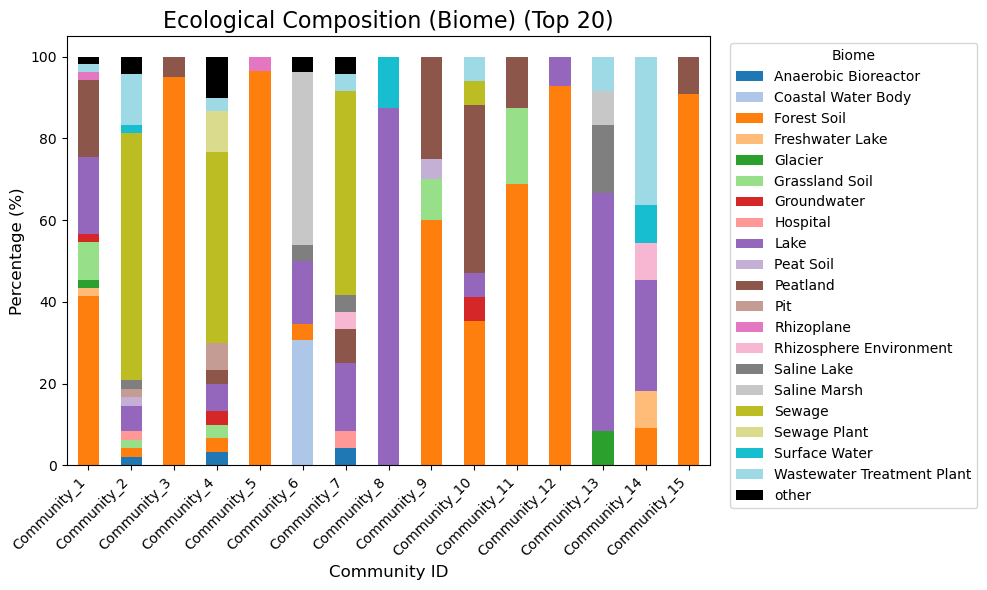

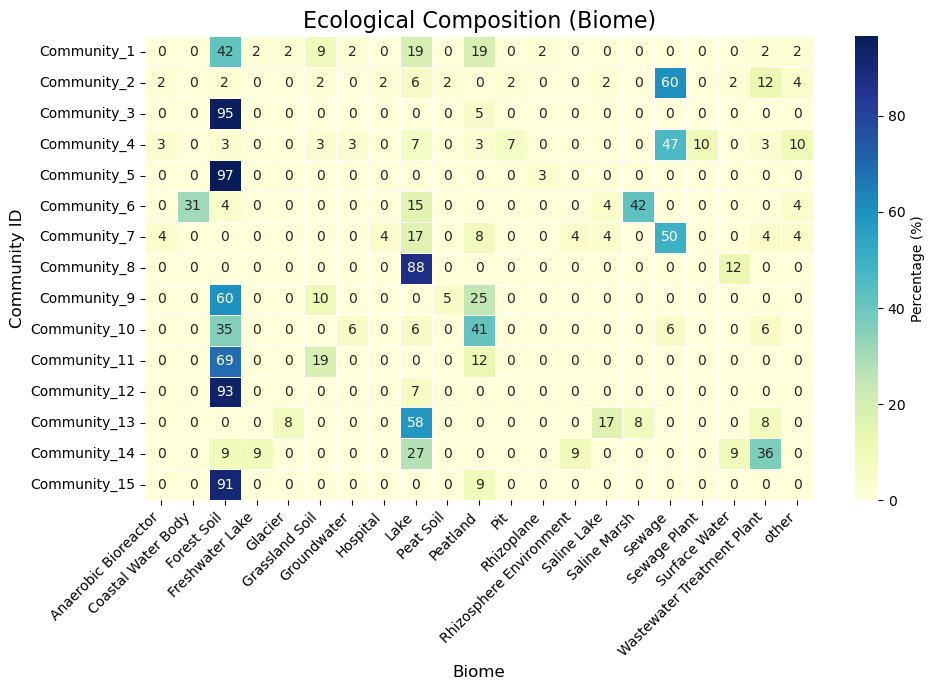

ANALYSIS: Community vs. product_categories
Note: Grouped -15 rare categories into 'Other'.


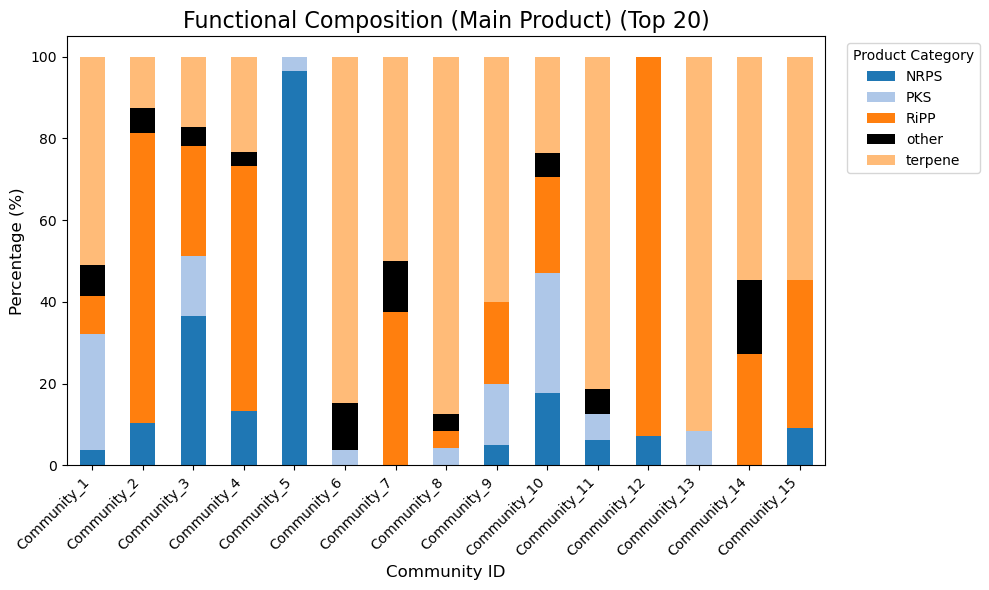

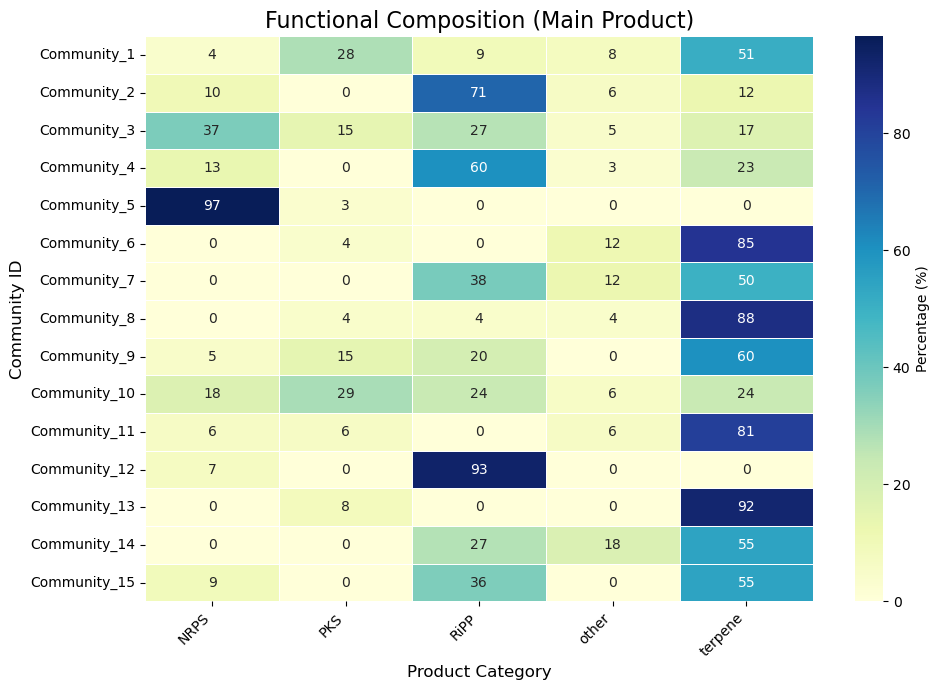

ANALYSIS: Community vs. product_subcategory
Note: Grouped 10 rare categories into 'Other'.


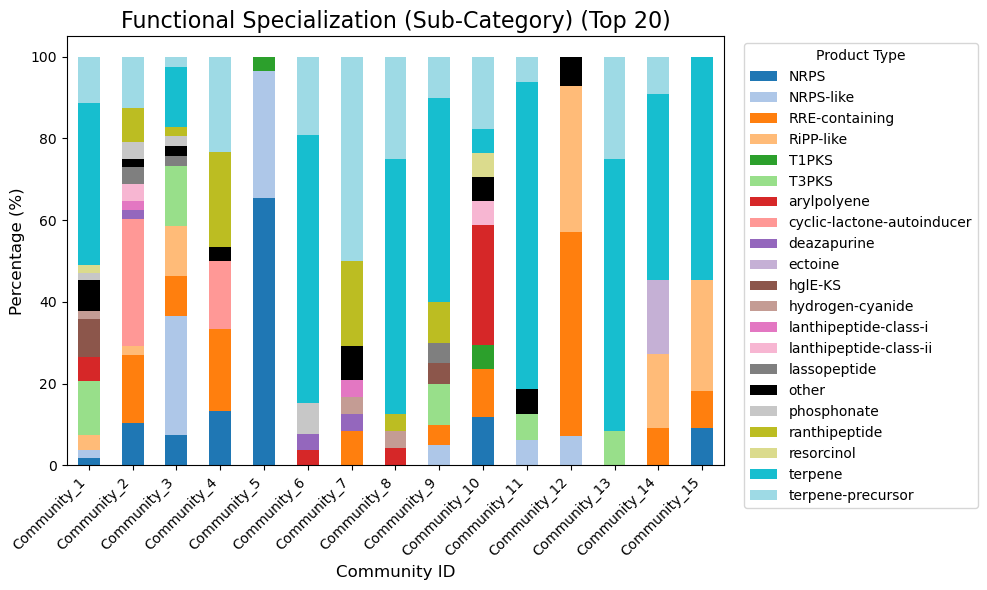

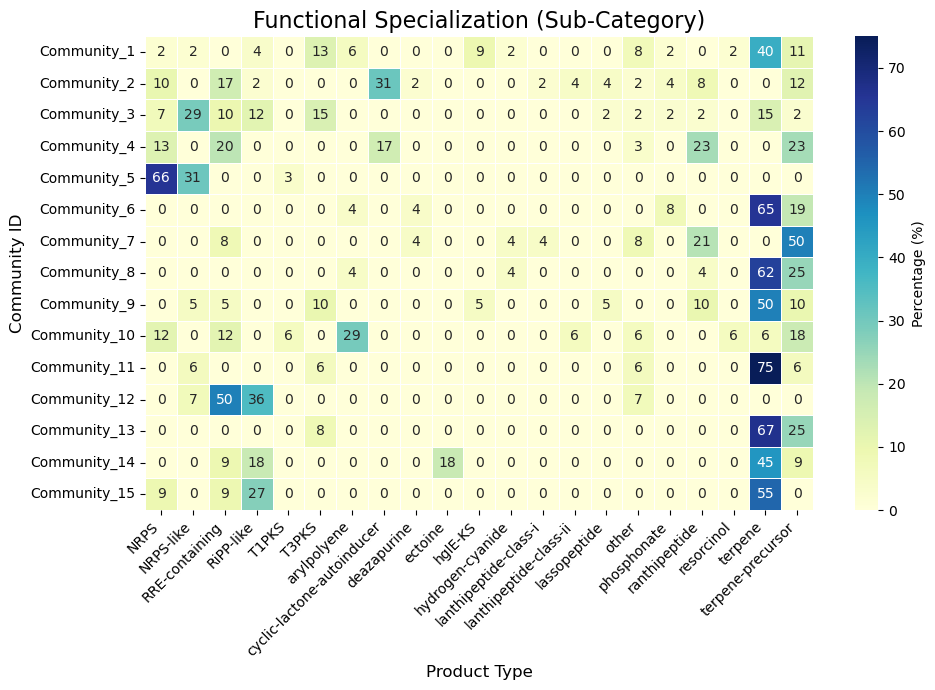

ANALYSIS: Community vs. genus_id
Note: Grouped 137 rare categories into 'Other'.


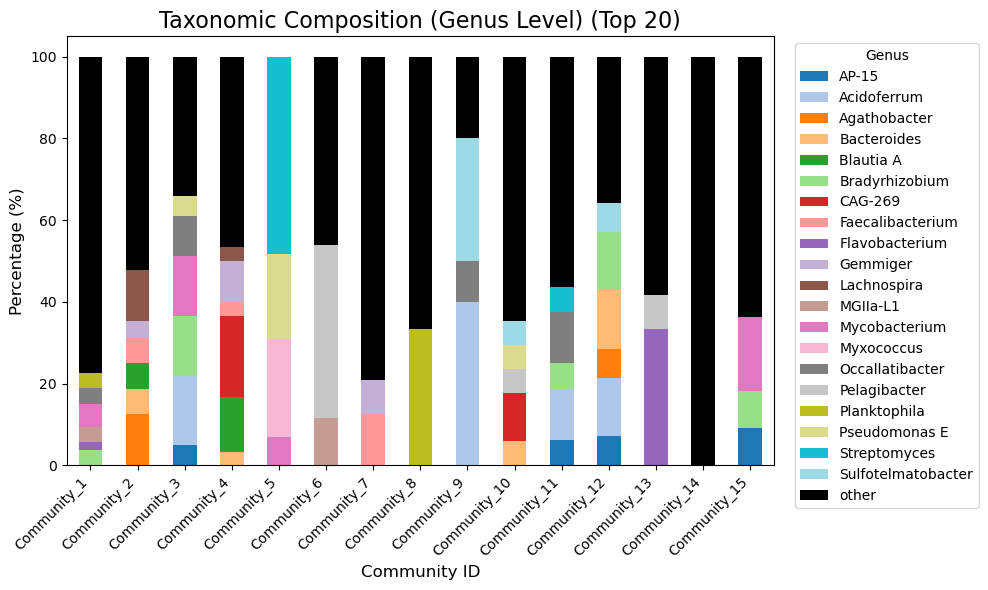

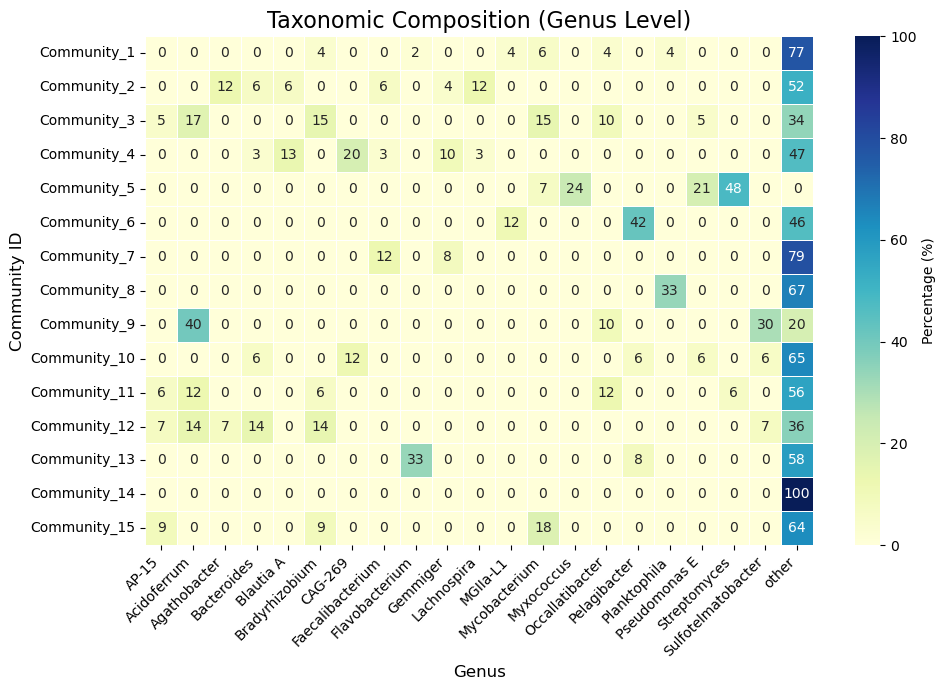

ANALYSIS: Community vs. family_id
Note: Grouped 69 rare categories into 'Other'.


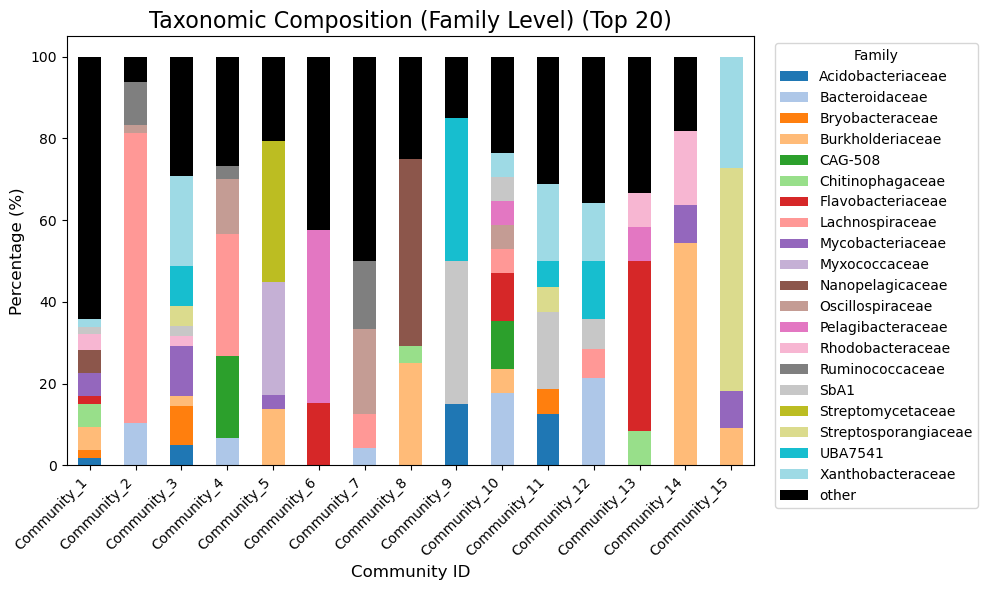

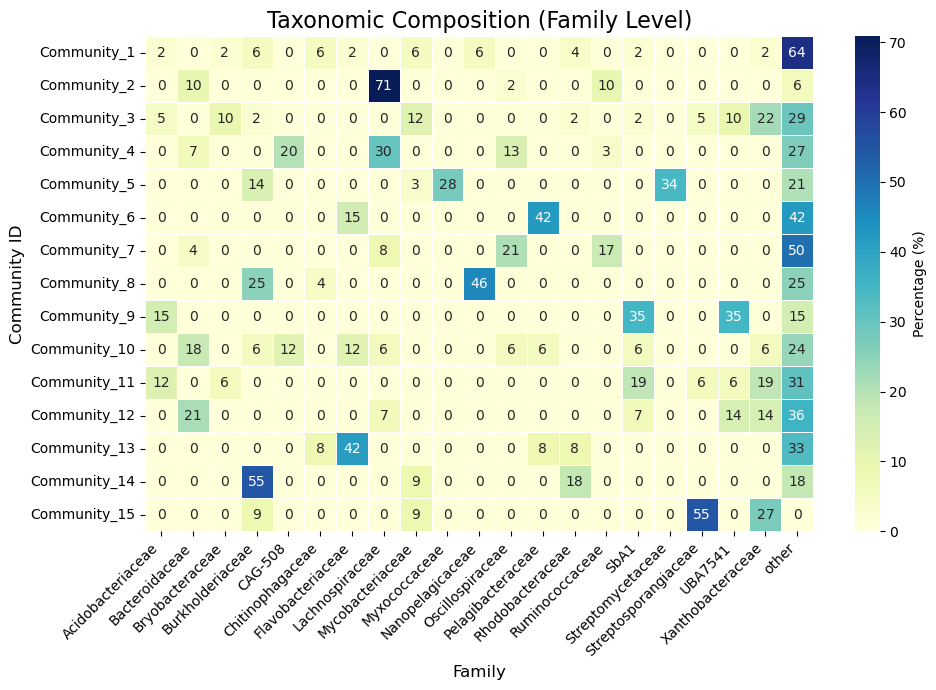

ANALYSIS: Community vs. species_id
Note: Grouped 269 rare categories into 'Other'.


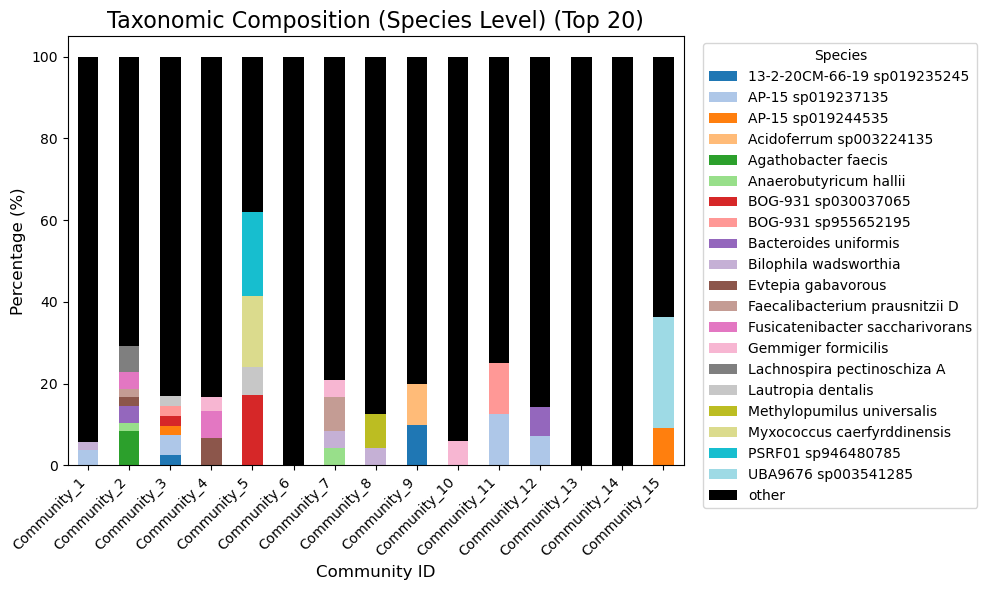

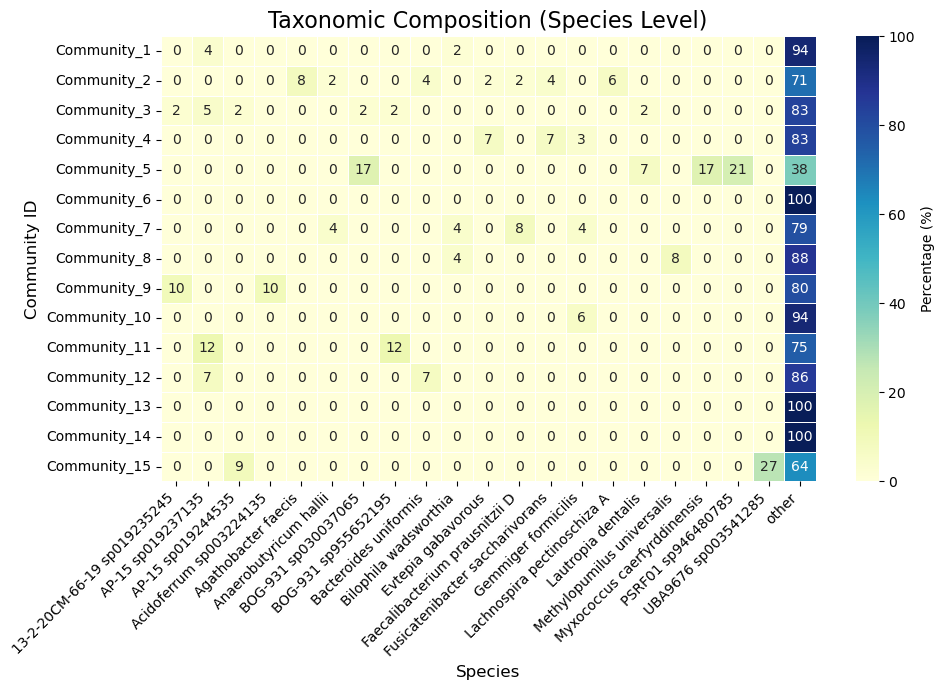

In [15]:
# 1. Ecological Niche (Biome)
analyze_community_composition(
    G_core, 
    attribute_name='dominant_biome', 
    plot_title='Ecological Composition (Biome)', 
    legend_title='Biome'
)

# Functional Potential
analyze_community_composition(
    G_core, 
    attribute_name='product_categories', 
    plot_title='Functional Composition (Main Product)', 
    legend_title='Product Category',
)

# Functional Specialization (Sub-Category)
analyze_community_composition(
    G_core, 
    attribute_name='product_subcategory', 
    plot_title='Functional Specialization (Sub-Category)', 
    legend_title='Product Type',
    top_n=20
)


# Taxonomy (Genus Level)
analyze_community_composition(
    G_core, 
    attribute_name='genus_id', 
    plot_title='Taxonomic Composition (Genus Level)', 
    legend_title='Genus',
    top_n=20
)

# Taxonomy (Family Level)
analyze_community_composition(
    G_core, 
    attribute_name='family_id', 
    plot_title='Taxonomic Composition (Family Level)', 
    legend_title='Family',
    top_n=20
)

# Taxanomy (Species Level)
analyze_community_composition(
    G_core, 
    attribute_name='species_id', 
    plot_title='Taxonomic Composition (Species Level)', 
    legend_title='Species',
    top_n=20
)


# Visualization: Deep Dive

DEEP DIVE HEATMAP: dominant_biome
Showing 7 categories that are >20% abundant in at least one cluster.


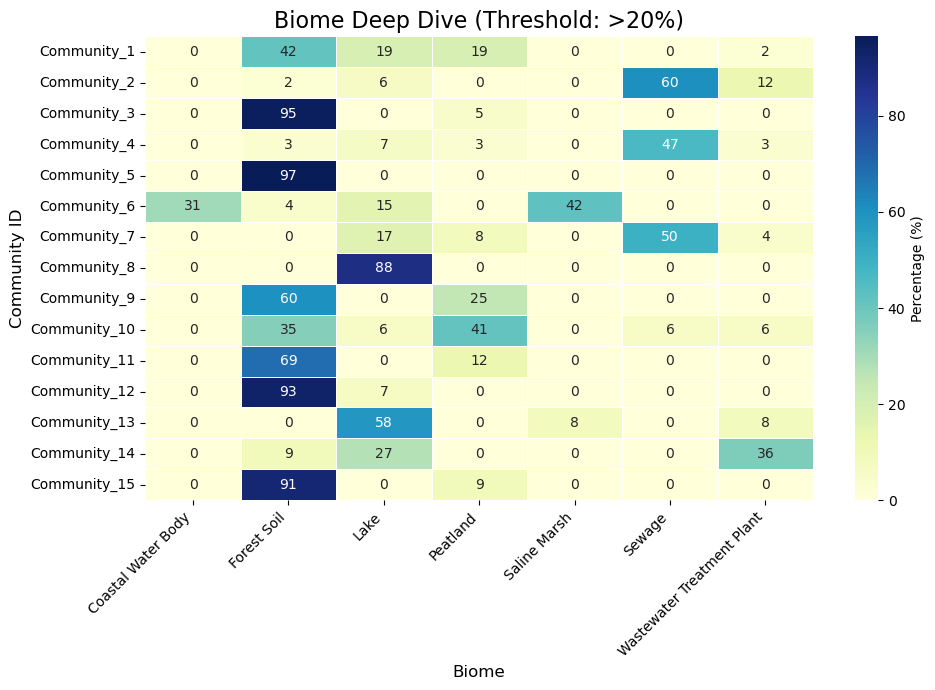

DEEP DIVE HEATMAP: product_categories
Showing 4 categories that are >10% abundant in at least one cluster.


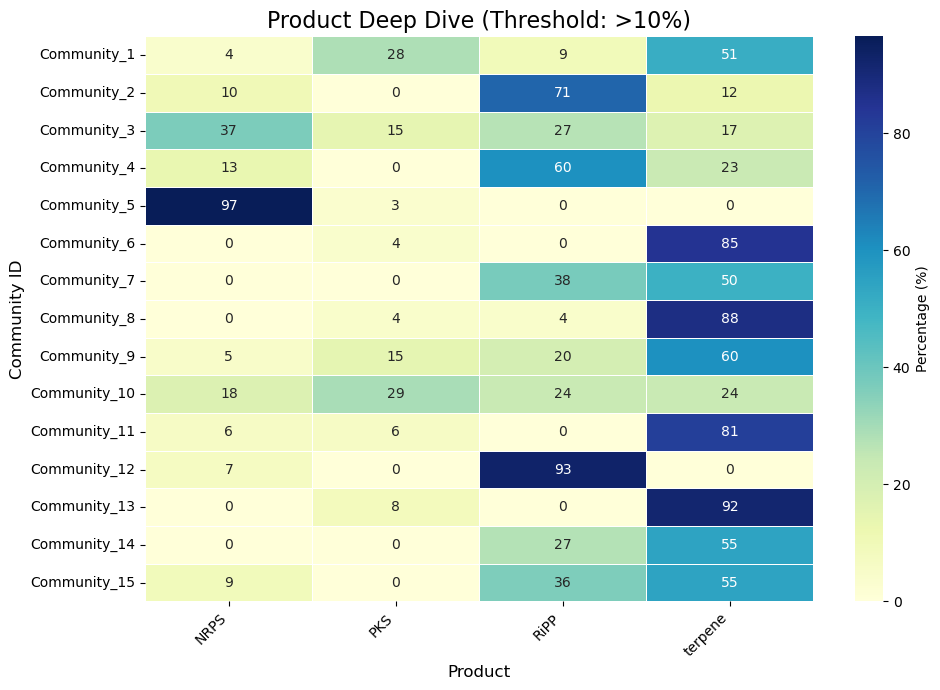

DEEP DIVE HEATMAP: product_subcategory
Showing 11 categories that are >10% abundant in at least one cluster.


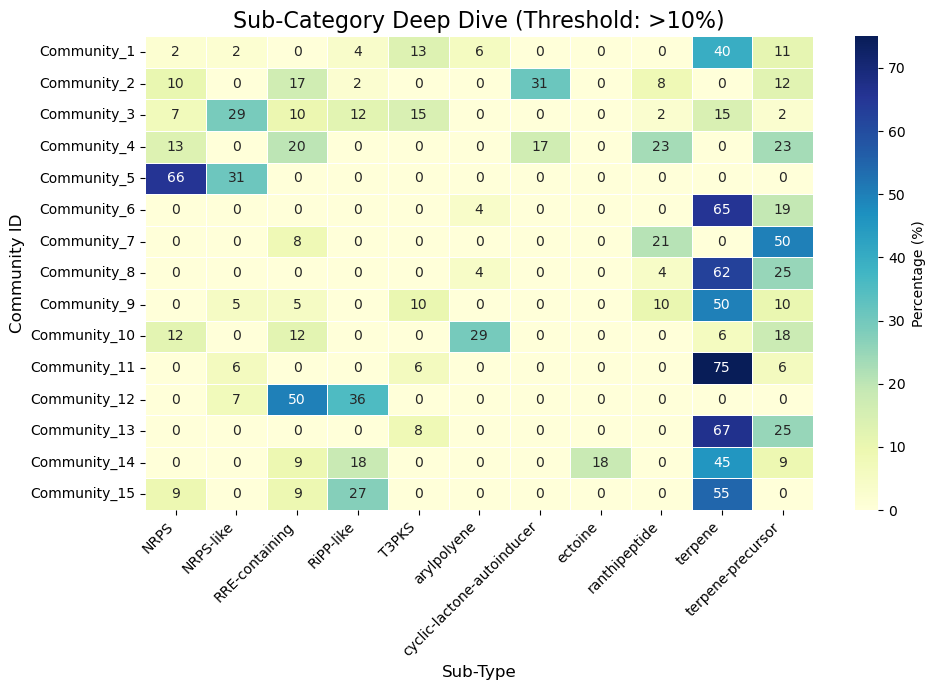

DEEP DIVE HEATMAP: genus_id
Showing 28 categories that are >10% abundant in at least one cluster.


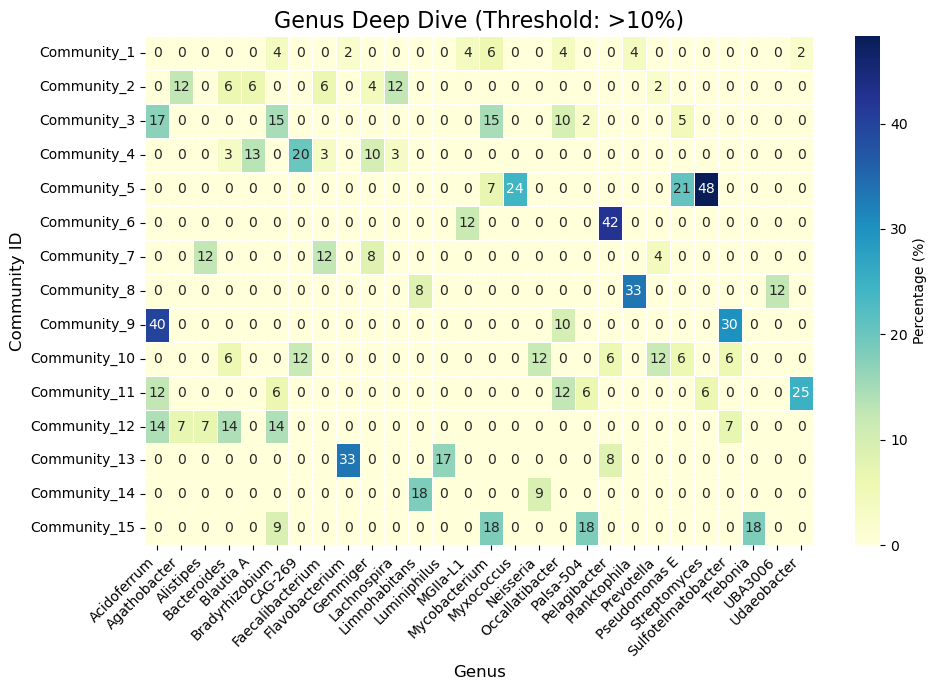

DEEP DIVE HEATMAP: family_id
Showing 26 categories that are >10% abundant in at least one cluster.


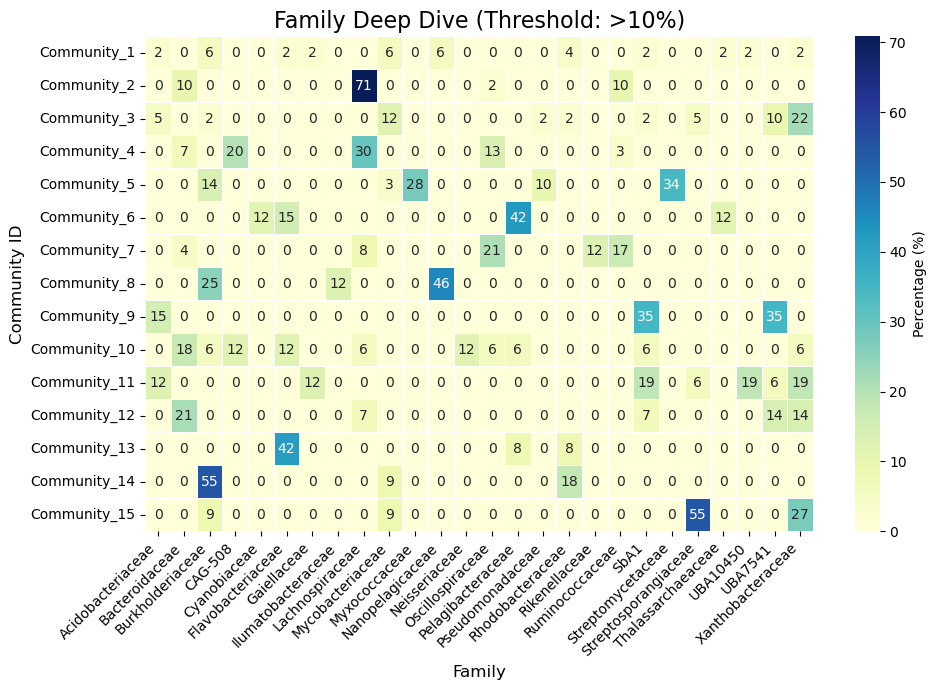

DEEP DIVE HEATMAP: species_id
Showing 10 categories that are >10% abundant in at least one cluster.


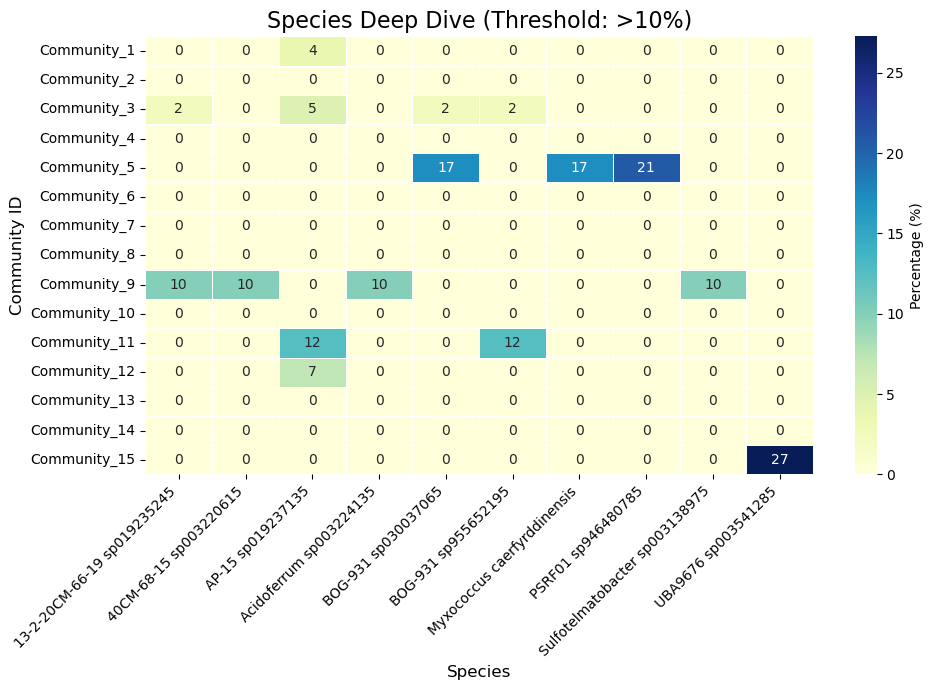

In [16]:
# RUN DEEP DIVE ANALYSES

# Biome
plot_deep_dive_heatmap(G_core, 'dominant_biome', 'Biome Deep Dive', 'Biome', threshold_percent=20)

# Product
plot_deep_dive_heatmap(G_core, 'product_categories', 'Product Deep Dive', 'Product', threshold_percent=10)

# Product Subcategories
plot_deep_dive_heatmap(G_core, 'product_subcategory', 'Sub-Category Deep Dive', 'Sub-Type', threshold_percent=10)

# Taxonomy Genus
plot_deep_dive_heatmap(G_core, 'genus_id', 'Genus Deep Dive', 'Genus', threshold_percent=10)

# Taxonomy Family
plot_deep_dive_heatmap(G_core, 'family_id', 'Family Deep Dive', 'Family', threshold_percent=10)

# Taxonomy Species
plot_deep_dive_heatmap(G_core, 'species_id', 'Species Deep Dive', 'Species', threshold_percent=10)

In [17]:
current_graph = G_core 
current_partition = partition   # The corresponding partition dictionary

disconnected_communities = []

# Iterate over all unique community IDs
for comm_id in set(current_partition.values()):
    # Get all nodes belonging to this community
    nodes = [n for n, c in current_partition.items() if c == comm_id]
    
    # Create a subgraph comprising only these nodes
    subgraph = current_graph.subgraph(nodes)
    
    # Check if this subgraph is fully connected
    if not nx.is_connected(subgraph):
        disconnected_communities.append(comm_id)

print(f"Number of disconnected communities: {len(disconnected_communities)}")

if len(disconnected_communities) > 0:
    print(f"Affected IDs: {disconnected_communities}")
else:
    print("All communities are perfectly connected!")

Number of disconnected communities: 1
Affected IDs: [14]


In [18]:
# Extract the subgraph for Community 14
nodes_c14 = [n for n, c in current_partition.items() if c == 14]
sub_c14 = current_graph.subgraph(nodes_c14)

print(f"Community 14 contains {len(nodes_c14)} nodes and {sub_c14.number_of_edges()} internal edges.")

# Check if the community is internally connected
if not nx.is_connected(sub_c14):
    components = list(nx.connected_components(sub_c14))
    print(f"The sub-network splits into {len(components)} disconnected components.")
    for i, comp in enumerate(components):
        print(f" - Component {i+1} contains {len(comp)} nodes: {comp}")

Community 14 contains 9 nodes and 7 internal edges.
The sub-network splits into 2 disconnected components.
 - Component 1 contains 2 nodes: {'GCF_09fc776728', 'GCF_532b91e4b5'}
 - Component 2 contains 7 nodes: {'GCF_38b9f80cf0', 'GCF_9fedce4a3d', 'GCF_37af0c2c8a', 'GCF_cbd03a8f17', 'GCF_cf18c2d2e7', 'GCF_ecd5e79774', 'GCF_b9481eeef2'}


In [19]:
# Selecting one node from Part 1 and one from Part 2
node_a = 'GCF_9fedce4a3d' # From Part 1 (7-member group)
node_b = 'GCF_09fc776728' # From Part 2 (2-member group)

# Check if a direct edge exists in the GLASSO graph
if current_graph.has_edge(node_a, node_b):
    print(f"DIRECT EDGE EXISTS in Python between {node_a} and {node_b}!")
else:
    print(f"NO DIRECT EDGE found in Python.")

# Check if ANY path exists (potentially through other communities)
if nx.has_path(current_graph, node_a, node_b):
    path = nx.shortest_path(current_graph, node_a, node_b)
    print(f"PATH FOUND! However, it is {len(path)-1} steps long and goes through: {path}")
else:
    print("NO PATH: These two groups are completely disconnected in the GLASSO network.")

NO DIRECT EDGE found in Python.
PATH FOUND! However, it is 3 steps long and goes through: ['GCF_9fedce4a3d', 'GCF_af8dca7f7e', 'GCF_16979f5209', 'GCF_09fc776728']


In [20]:
# 1. Convert network partition to a DataFrame
df_communities = pd.DataFrame(list(partition.items()), columns=['gcf_id', 'community_id'])

counts = df_communities['community_id'].value_counts()

rank_mapping = {old_id: rank + 1 for rank, old_id in enumerate(counts.index)}

# Wende das Mapping an
df_communities['community_id'] = df_communities['community_id'].map(rank_mapping)
# ---------------------------------

# 2. Merge community info with the BGC data
df_result = pd.merge(df_communities, df_merged, on='gcf_id', how='inner')

# 3. Rename columns to the desired format
df_result = df_result.rename(columns={
    'community_id': 'Community', 
    'gcf_id': 'GCF', 
    'filename': 'BGC'
})

# 4. SMART SORTING (Crucial Step)
# We sort by Community and GCF, but also by 'is_complete' if available.
# Ascending=[True, True, False] means:
# - Community 0->9
# - GCF A->Z
# - is_complete: TRUE (top) -> FALSE (bottom).
# This ensures the BEST BGC is always the first one listed for its group.
if 'is_complete' in df_result.columns:
    df_result = df_result.sort_values(by=['Community', 'GCF', 'is_complete'], 
                                      ascending=[True, True, False])
else:
    # Fallback if 'is_complete' is missing
    df_result = df_result.sort_values(by=['Community', 'GCF'])

# 5. STRICTLY select only the requested columns
# Now we remove the helper columns (like is_complete), keeping only the 3 you wanted.
df_result = df_result[['Community', 'GCF', 'BGC']]

# 6. Drop Duplicates
# Since we sorted above, we keep the highest quality entry if duplicates exist.
df_result = df_result.drop_duplicates()
print(f"Rows after cleanup: {len(df_result)}")

# 7. Save the clean table to a CSV file
output_path = "../data/Glasso_Community_GCF_BGC_Table.csv"
df_result.to_csv(output_path, index=False)

Rows after cleanup: 5884716


In [21]:
# 1. Determine the highest community ID
max_id = max(partition.values())
print(f"Highest Community ID in GLASSO: {max_id}")

# 2. Check the total number of GCFs in the partition
print(f"Total number of GCFs with community assignment: {len(partition)}")

# 3. Verify if the community IDs are continuous (no gaps)
all_ids = sorted(list(set(partition.values())))
print(f"Existing IDs: {all_ids}")

Highest Community ID in GLASSO: 22
Total number of GCFs with community assignment: 440
Existing IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
